В этом ноутбуке продемонстрирован весь пайплайн работы симулятора на датасете Amazon: генерация эмбеддингов профилей пользователей, обучение моделей генерации синтетических профилей пользователей, обучение функции отклика, обучение рекомендательной системы UCB путем взаимодействия с симулятором.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import time

import numpy as np
import pandas as pd

from pyspark.sql import SparkSession
from replay.session_handler import State

from sklearn.metrics import roc_auc_score, precision_score, recall_score

import pyspark.sql.functions as sf
import pyspark.ml.functions as smf
from pyspark.ml.feature import VectorAssembler, PCA
from pyspark.ml import Pipeline
from pyspark.ml.classification import (
    LogisticRegression, RandomForestClassifier
)

from replay.metrics import NDCG, Precision, RocAuc
from replay.data_preparator import Indexer
from replay.models import RandomRec
from ucb import UCB

from simulator.modules import (
    SDVDataGenerator, RealDataGenerator,
    Simulator, evaluate_synthetic,
    EvaluateMetrics
)
from simulator.response import BernoulliResponse, ParametricResponseFunction
from simulator.utils import VectorElementExtractor, pandas_to_spark

from datautils import read_amazon

%matplotlib inline
import matplotlib.pyplot as plt

SPARK_LOCAL_DIR = '/data/home/anthony/tmp'
CHECKPOINT_DIR = '/data/home/anthony/tmp/checkpoints'
DATA_PATH = r'file:///mnt/dgxhome/home/estavinova/simulator/Amazon/home'
MODELS_DIR = '../bin'

spark = SparkSession.builder\
    .appName('simulator_amazon')\
    .master('local[16]')\
    .config('spark.sql.shuffle.partitions', '16')\
    .config('spark.default.parallelism', '16')\
    .config('spark.driver.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.executor.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.sql.autoBroadcastJoinThreshold', '250m')\
    .config('spark.driver.memory', '256g')\
    .config('spark.kryoserializer.buffer.max', '128m')\
    .config('spark.local.dir', SPARK_LOCAL_DIR)\
    .getOrCreate()

State(spark)

22/11/25 14:10:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/11/25 14:10:55 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


In [2]:
def test_model(model_class, train_data, test_data, assembler, extractor):
    model = model_class(featuresCol='features', labelCol='relevance', probabilityCol='__prob_vec', predictionCol='response')

    start = time.time()
    pipeline = Pipeline(stages=[assembler, model, extractor]).fit(train_data)
    train_time = time.time() - start

    pred_pdf = pipeline\
        .transform(test_data)\
        .select('relevance', '__prob_raw', 'item_rating_avg', 'response')\
        .toPandas()

    pred_pdf['baseline_prob'] =\
        (pred_pdf['item_rating_avg'] - pred_pdf['item_rating_avg'].min()) /\
        (pred_pdf['item_rating_avg'].max() - pred_pdf['item_rating_avg'].min())
    pred_pdf['baseline_bin'] = np.where(pred_pdf['baseline_prob'] >= 0.5, 1, 0)

    roc_auc_model = roc_auc_score(pred_pdf.relevance, pred_pdf.__prob_raw)
    roc_auc_baseline = roc_auc_score(pred_pdf.relevance, pred_pdf.baseline_prob)

    precision_model = precision_score(pred_pdf.relevance, pred_pdf.response)
    precision_baseline = precision_score(pred_pdf.relevance, pred_pdf.baseline_bin)

    recall_model = recall_score(pred_pdf.relevance, pred_pdf.response)
    recall_baseline = recall_score(pred_pdf.relevance, pred_pdf.baseline_bin)

    return train_time, pred_pdf,\
           {
            'roc_auc' : roc_auc_model,
            'precision' : precision_model,
            'recall' : recall_model
           },\
           {
            'roc_auc' : roc_auc_baseline,
            'precision' : precision_baseline,
            'recall' : recall_baseline
           }

Работаем с предобработанными данными, которые разделены на три части по времени выставления рейтинга. Оценки 1 и 2 считаем отрицательными (0); 3, 4 и 5 -- положительными (1).

Данные были предварительно предобработаны (код в папке Amazon): составлены профили польззователей и предложений по истории откликов, а также данные разделены по времени выставления оценок на обучающую, валидационную и тестовую выборки.

In [3]:
users_df_train, items_df_train, log_df_train = read_amazon(DATA_PATH, 'train', spark)

users_df_train = users_df_train.cache()
items_df_train = items_df_train.cache()
log_df_train = log_df_train.cache()

users_df_train.count()
items_df_train.count()
log_df_train.count()

22/11/25 14:11:37 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


14668620

In [4]:
users_df_val, items_df_val, log_df_val = read_amazon(DATA_PATH, 'val', spark)

users_df_val = users_df_val.cache()
items_df_val = items_df_val.cache()
log_df_val = log_df_val.cache()

users_df_val.count()
items_df_val.count()
log_df_val.count()

7377984

In [5]:
users_df_test, items_df_test, log_df_test = read_amazon(DATA_PATH, 'test', spark)

users_df_test = users_df_test.cache()
items_df_test = items_df_test.cache()
log_df_test = log_df_test.cache()

users_df_test.count()
items_df_test.count()
log_df_test.count()

7399807

# Генерация эмбеддингов

В результате экспериментального исследования методов генерации эмбеддингов (amazon_embeddings.ipynb) было решено использовать метод главных компонент в случае датасета Amazon. Далее с помощью этого метода генерируются профили пользователей.

In [6]:
pca_va = VectorAssembler(
    inputCols=['user_helpfulness', 'user_rating_avg'] + [f'user_w2v_{i}' for i in range(300)],
    outputCol='features'
)
pca_estimator = PCA(k=10, inputCol='features', outputCol='pca_features')

pca = Pipeline(stages=[pca_va, pca_estimator]).fit(users_df_train)

22/11/25 14:17:03 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/11/25 14:17:03 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
22/11/25 14:17:18 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
22/11/25 14:17:18 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


In [7]:
users_df_train_new = pca.transform(users_df_train)\
    .select('user_id', 'pca_features')\
    .withColumn('user_features', smf.vector_to_array('pca_features'))\
    .select(['user_id'] + [sf.col('user_features')[i] for i in range(10)])\
    .cache()

users_df_train.unpersist()
users_df_train = users_df_train_new

users_df_val_new = pca.transform(users_df_val)\
    .select('user_id', 'pca_features')\
    .withColumn('user_features', smf.vector_to_array('pca_features'))\
    .select(['user_id'] + [sf.col('user_features')[i] for i in range(10)])\
    .cache()

users_df_val.unpersist()
users_df_val = users_df_val_new

pca_va.setInputCols(['item_helpfulness', 'item_rating_avg'] + [f'item_w2v_{i}' for i in range(300)])

items_df_train_new = pca.transform(items_df_train)\
    .select('item_id', 'pca_features', 'item_rating_avg')\
    .withColumn('item_features', smf.vector_to_array('pca_features'))\
    .select(['item_id', 'item_rating_avg'] + [sf.col('item_features')[i] for i in range(10)])\
    .cache()

items_df_train.unpersist()
items_df_train = items_df_train_new

items_df_val_new = pca.transform(items_df_val)\
    .select('item_id', 'pca_features', 'item_rating_avg')\
    .withColumn('item_features', smf.vector_to_array('pca_features'))\
    .select(['item_id', 'item_rating_avg'] + [sf.col('item_features')[i] for i in range(10)])\
    .cache()

items_df_val.unpersist()
items_df_val = items_df_val_new

items_df_test_new = pca.transform(items_df_test)\
    .select('item_id', 'pca_features', 'item_rating_avg')\
    .withColumn('item_features', smf.vector_to_array('pca_features'))\
    .select(['item_id', 'item_rating_avg'] + [sf.col('item_features')[i] for i in range(10)])\
    .cache()

items_df_test.unpersist()
items_df_test = items_df_test_new

# Обучение генератора

Также в ноутбуке amazon_embeddings.ipynb был сделан вывод о том, что модель генерации CopulaGAN является наиболее подходящей в случае датасета Amazon и эмбеддингов на основе PCA. Поэтому здесь будет использована именно эта модель.

In [8]:
# user_generator = SDVDataGenerator(
#     label='synth_user',
#     id_column_name='user_id',
#     model_name='copulagan',
#     parallelization_level=8,
#     device_name='cpu',
#     seed=1234
# )

# user_generator.fit(users_df_train)
# user_generator.save_model(f'{MODELS_DIR}/amazon_pca_users_copulagan.pkl')

user_generator = SDVDataGenerator.load(f'{MODELS_DIR}/amazon_pca_users_copulagan.pkl')
user_generator.setDevice('cpu')
user_generator.setParallelizationLevel(16)

users_synth = user_generator.generate(80650)

eval_frac = 1000 / users_df_train.count()
gen_score = evaluate_synthetic(
    synth_df=users_synth.sample(1000 / user_generator.getDataSize()).drop('user_id'),
    real_df=users_df_train.sample(1000 / users_df_train.count()).drop('user_id')
)

gen_score

{'LogisticDetection': 0.6393818216384144,
 'SVCDetection': 0.4554977647997457,
 'KSTest': 0.9010906714425679,
 'ContinuousKLDivergence': 0.7518562406721726}

In [9]:
item_generator = RealDataGenerator(label='real_item', seed=1234)
item_generator.fit(items_df_test)
_ = item_generator.generate(27278)

22/11/24 10:05:51 WARN CacheManager: Asked to cache already cached data.


# Инициализация симулятора

In [10]:
simulator = Simulator(
    user_gen=user_generator,
    item_gen=item_generator,
    user_key_col='user_id',
    item_key_col='item_id',
    spark_session=spark,
    data_dir=f'{CHECKPOINT_DIR}/amazon_response'
)

# Обучение регрессии

Необходимо определить, какая модель отклика наиболее точно приближает отклик, присутствующий в исторических данных. В качестве кандидатов использованы три модели:

-- Logistic Regression;

-- Random Forest;

-- Matrix Factorization.

Напомним, что профили пользователей и предложений, относящиеся к периоду train (users_df_train и items_df_train соответственно) построены по истории взаимодействий из log_df_train. Поэтому для обучения модели отклика используются профили пользователей users_df_train и предложений items_df_train, а также лог log_df_val. Для оценки качества модели отклика используются профили users_df_val и items_df_val, построенные по объединенному логу log_df_train и log_df_val, а также лог log_df_test.

In [8]:
feature_cols = [f'user_features[{i}]' for i in range(10)] +\
               [f'item_features[{i}]' for i in range(10)]

assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
extractor = VectorElementExtractor(inputCol='__prob_vec', outputCol='__prob_raw', index=1)
multiplier = ParametricResponseFunction(inputCols=['__prob_raw'], outputCol='__prob', weights=[0.25])
bernoulli = BernoulliResponse(inputCol='__prob', outputCol='response', seed=1234)

train_df = log_df_val\
    .sample(100000 / log_df_val.count())\
    .drop('timestamp')\
    .join(users_df_train, on='user_id', how='left')\
    .join(items_df_train, on='item_id', how='left')\
    .na.drop()\
    .cache()

test_df = log_df_test\
    .sample(100000 / log_df_test.count())\
    .drop('timestamp')\
    .join(users_df_val, on='user_id', how='left')\
    .join(items_df_val, on='item_id', how='left')\
    .na.drop()\
    .cache()

# Качество логистической регрессии

In [9]:
lr_time, lr_pdf, lr_model_metrics, lr_baseline_metrics = test_model(
    model_class=LogisticRegression,
    train_data=train_df,
    test_data=test_df,
    assembler=assembler,
    extractor=extractor
)

LogisticRegression pipeline train time: 39.49808931350708
LogisticRegression metrics: {'roc_auc': 0.7048138219983218, 'precision': 0.8823666124373319, 'recall': 0.9937925360855583}
Baseline metrics:           {'roc_auc': 0.6492912643616794, 'precision': 0.8852331518614953, 'recall': 0.9789469747962007}


<AxesSubplot: >

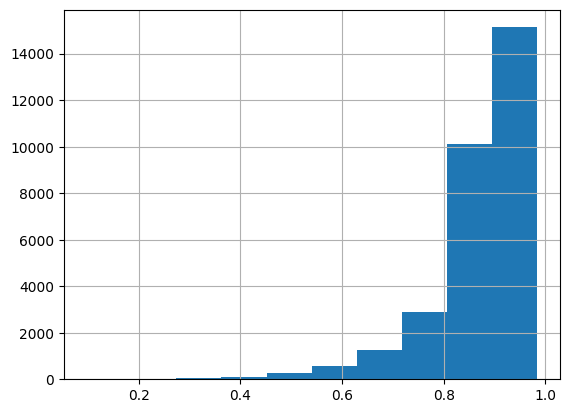

In [10]:
print(f'LogisticRegression pipeline train time: {lr_time}')
print(f'LogisticRegression metrics: {lr_model_metrics}')
print(f'Baseline metrics:           {lr_baseline_metrics}')

lr_pdf['__prob_raw'].hist()

# Качество случайного леса

In [11]:
rf_time, rf_pdf, rf_model_metrics, rf_baseline_metrics = test_model(
    model_class=RandomForestClassifier,
    train_data=train_df,
    test_data=test_df,
    assembler=assembler,
    extractor=extractor
)

RandomForestClassifier pipeline train time: 7.780652046203613
RandomForestClassifier metrics: {'roc_auc': 0.694284667458861, 'precision': 0.8792372184777248, 'recall': 1.0}
Baseline metrics:               {'roc_auc': 0.6492912643616794, 'precision': 0.8852331518614953, 'recall': 0.9789469747962007}


<AxesSubplot: >

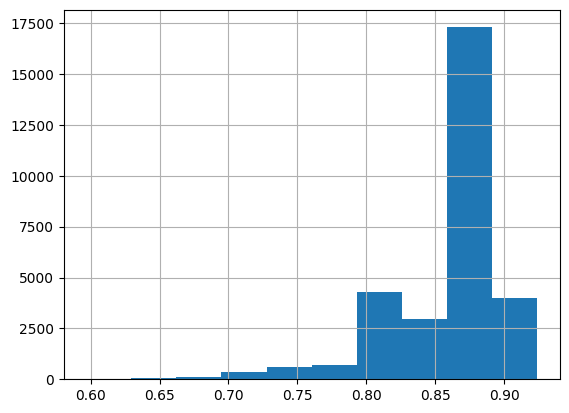

In [12]:
print(f'RandomForestClassifier pipeline train time: {rf_time}')
print(f'RandomForestClassifier metrics: {rf_model_metrics}')
print(f'Baseline metrics:               {rf_baseline_metrics}')

rf_pdf['__prob_raw'].hist()

# Обучение рексистемы

Далее будем в цикле обучать рекомендательную систему на откликах синтетических пользователей, полученных с помощью симулятора.

In [16]:
lr = LogisticRegression(featuresCol='features', labelCol='relevance', probabilityCol='__prob_vec')
pipeline = Pipeline(stages=[assembler, lr, extractor, multiplier, bernoulli]).fit(train_df)

В качестве бейзлайна будем использовать рекомендательную систему, которая предлагает пользователю случайные предложения.

In [17]:
indexer = Indexer(user_col='user_id', item_col='item_id')
indexer.fit(users=user_generator.sample(1.0), items=item_generator.sample(1.0))

dummy_log = pandas_to_spark(pd.DataFrame({'user_id' : [1], 'item_id' : [1], 'relevance' : [0.0]}))

ucb = UCB(sample=True)
ucb.fit(indexer.transform(dummy_log))

random_rec = RandomRec(distribution='uniform')
random_rec.fit(indexer.transform(dummy_log))

22/11/24 10:08:21 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/11/24 10:08:21 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/11/24 10:08:22 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/11/24 10:08:26 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/11/24 10:08:26 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/11/24 10:08:27 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


In [18]:
evaluator = EvaluateMetrics(
    userKeyCol='user_id',
    itemKeyCol='item_id',
    predictionCol='relevance',
    labelCol='response',
    replay_label_filter=1.0,
    replay_metrics={NDCG() : 10, Precision() : 10, RocAuc(): 10}
)

In [19]:
user_frac = 10000 / user_generator.getDataSize()
item_frac = 0.4

users_replay = indexer.transform(user_generator.sample(1.0)).cache()
items_replay = indexer.transform(item_generator.sample(1.0)).cache()
users_replay.count()
items_replay.count()

spark.sparkContext.setLogLevel('ERROR')

22/11/24 10:08:30 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/11/24 10:08:31 WARN DAGScheduler: Broadcasting large task binary with size 1109.7 KiB


In [20]:
random_rec_simulator = Simulator(None, None, f'{CHECKPOINT_DIR}/amazon_response_rnd', None, 'user_id', 'item_id', spark)

ucb_metrics = []
rnd_metrics = []
for i in range(200):
    iter_start = time.time()

    # users = simulator.sample_users(user_frac).cache()
    # items = simulator.sample_items(item_frac).cache()
    users = users_replay.sample(user_frac).withColumnRenamed('user_idx', 'user_id').cache()
    items = items_replay.sample(item_frac).withColumnRenamed('item_idx', 'item_id').cache()
    log = simulator.get_log(users)
    log = dummy_log if log is None else log
    log = log.cache()

    recs_ucb = ucb.predict(
        log=log.withColumnRenamed('user_id', 'user_idx').withColumnRenamed('item_id', 'item_idx'),
        k=10,
        users=users.withColumnRenamed('user_id', 'user_idx'),
        items=items.withColumnRenamed('item_id', 'item_idx'),
        filter_seen_items=False
    )
    recs_ucb = recs_ucb.withColumnRenamed('user_idx', 'user_id').withColumnRenamed('item_idx', 'item_id').cache()
    recs_rnd = random_rec.predict(
        log=log.withColumnRenamed('user_id', 'user_idx').withColumnRenamed('item_id', 'item_idx'),
        k=10,
        users=users.withColumnRenamed('user_id', 'user_idx'),
        items=items.withColumnRenamed('item_id', 'item_idx'),
        filter_seen_items=False
    )
    recs_rnd = recs_rnd.withColumnRenamed('user_idx', 'user_id').withColumnRenamed('item_idx', 'item_id').cache()

    resp_ucb = simulator.sample_responses(
        recs_df=recs_ucb,
        user_features=users,
        item_features=items,
        action_models=pipeline
    ).select('user_id', 'item_id', 'relevance', 'response').cache()
    resp_rnd = simulator.sample_responses(
        recs_df=recs_rnd,
        user_features=users,
        item_features=items,
        action_models=pipeline
    ).select('user_id', 'item_id', 'relevance', 'response').cache()

    simulator.update_log(resp_ucb, iteration=i)
    random_rec_simulator.update_log(resp_rnd, iteration=i)

    ucb_metrics.append(evaluator(resp_ucb))
    rnd_metrics.append(evaluator(resp_rnd))

    ucb._clear_cache()
    ucb_train_log = simulator.log.cache()
    ucb.fit(log=ucb_train_log\
            .select('user_id', 'item_id', 'response')\
            .withColumnRenamed('user_id', 'user_idx')\
            .withColumnRenamed('item_id', 'item_idx')\
            .withColumnRenamed('response', 'relevance')
    )

    random_rec._clear_cache()
    rnd_train_log = random_rec_simulator.log.cache()
    random_rec.fit(log=rnd_train_log\
                   .select('user_id', 'item_id', 'response')\
                   .withColumnRenamed('user_id', 'user_idx')\
                   .withColumnRenamed('item_id', 'item_idx')\
                   .withColumnRenamed('response', 'relevance')\
                   .filter(sf.col('relevance') == 1)
    )

    users.unpersist()
    items.unpersist()
    log.unpersist()
    recs_ucb.unpersist()
    recs_rnd.unpersist()
    resp_ucb.unpersist()
    resp_rnd.unpersist()
    ucb_train_log.unpersist()
    rnd_train_log.unpersist()

    print(f'Iteration {i} finished in {time.time() - iter_start} sec.')

Iteration 0 finished in 35.90166640281677 sec.


Iteration 1 finished in 29.308420181274414 sec.


Iteration 2 finished in 30.360610008239746 sec.


Iteration 3 finished in 28.78508734703064 sec.


Iteration 4 finished in 28.392728567123413 sec.


Iteration 5 finished in 29.268290281295776 sec.


Iteration 6 finished in 28.237844467163086 sec.


Iteration 7 finished in 29.31024742126465 sec.


Iteration 8 finished in 28.71703553199768 sec.


Iteration 9 finished in 28.93287682533264 sec.


Iteration 10 finished in 29.764591455459595 sec.


Iteration 11 finished in 29.24774932861328 sec.


Iteration 12 finished in 29.15649652481079 sec.


Iteration 13 finished in 30.192562580108643 sec.


Iteration 14 finished in 29.949207305908203 sec.


Iteration 15 finished in 29.687405347824097 sec.


Iteration 16 finished in 30.446929454803467 sec.


Iteration 17 finished in 29.13624596595764 sec.


Iteration 18 finished in 30.434112310409546 sec.


Iteration 19 finished in 30.200799465179443 sec.


Iteration 20 finished in 29.870691537857056 sec.


Iteration 21 finished in 31.9560706615448 sec.


Iteration 22 finished in 29.376145601272583 sec.


Iteration 23 finished in 29.95547127723694 sec.


Iteration 24 finished in 30.28400230407715 sec.


Iteration 25 finished in 33.497905015945435 sec.


Iteration 26 finished in 29.56070566177368 sec.


Iteration 27 finished in 29.59890866279602 sec.


Iteration 28 finished in 29.260730028152466 sec.


Iteration 29 finished in 30.521612644195557 sec.


Iteration 30 finished in 30.050381183624268 sec.


Iteration 31 finished in 30.0104558467865 sec.


Iteration 32 finished in 31.544201612472534 sec.


Iteration 33 finished in 30.099329948425293 sec.


Iteration 34 finished in 29.323683977127075 sec.


Iteration 35 finished in 30.226963758468628 sec.


Iteration 36 finished in 30.260038375854492 sec.


Iteration 37 finished in 31.07921576499939 sec.


Iteration 38 finished in 30.34665060043335 sec.


Iteration 39 finished in 30.31348991394043 sec.


Iteration 40 finished in 30.95391297340393 sec.


Iteration 41 finished in 31.104208946228027 sec.


Iteration 42 finished in 58.037885665893555 sec.


Iteration 43 finished in 40.8510057926178 sec.


Iteration 44 finished in 40.392805337905884 sec.


Iteration 45 finished in 33.7695586681366 sec.


Iteration 46 finished in 31.130232572555542 sec.


Iteration 47 finished in 32.476733922958374 sec.


Iteration 48 finished in 31.236481428146362 sec.


Iteration 49 finished in 31.067506790161133 sec.


Iteration 50 finished in 31.81857180595398 sec.


Iteration 51 finished in 30.875041484832764 sec.


Iteration 52 finished in 31.204183340072632 sec.


Iteration 53 finished in 31.20327615737915 sec.


Iteration 54 finished in 31.37256145477295 sec.


Iteration 55 finished in 32.008787870407104 sec.


Iteration 56 finished in 31.37390160560608 sec.


Iteration 57 finished in 31.570752143859863 sec.


Iteration 58 finished in 31.076764822006226 sec.


Iteration 59 finished in 32.02345848083496 sec.


Iteration 60 finished in 31.73979353904724 sec.


Iteration 61 finished in 31.23337173461914 sec.


Iteration 62 finished in 31.634402751922607 sec.


Iteration 63 finished in 32.38668203353882 sec.


Iteration 64 finished in 30.694262266159058 sec.


Iteration 65 finished in 32.197152614593506 sec.


Iteration 66 finished in 33.392645597457886 sec.


Iteration 67 finished in 31.98621678352356 sec.


Iteration 68 finished in 31.615660905838013 sec.


Iteration 69 finished in 31.244457960128784 sec.


Iteration 70 finished in 31.8802752494812 sec.


Iteration 71 finished in 31.76144003868103 sec.


Iteration 72 finished in 32.23523259162903 sec.


Iteration 73 finished in 32.44639825820923 sec.


Iteration 74 finished in 32.18503522872925 sec.


Iteration 75 finished in 32.504809617996216 sec.


Iteration 76 finished in 32.058149337768555 sec.


Iteration 77 finished in 32.59255075454712 sec.


Iteration 78 finished in 32.77267265319824 sec.


Iteration 79 finished in 32.57498216629028 sec.


Iteration 80 finished in 32.20612359046936 sec.


Iteration 81 finished in 31.423950910568237 sec.


Iteration 82 finished in 32.44271516799927 sec.


Iteration 83 finished in 32.62031006813049 sec.


Iteration 84 finished in 33.66578984260559 sec.


Iteration 85 finished in 32.749064207077026 sec.


Iteration 86 finished in 31.96434760093689 sec.


Iteration 87 finished in 31.778598308563232 sec.


Iteration 88 finished in 33.17759728431702 sec.


Iteration 89 finished in 32.85515785217285 sec.


Iteration 90 finished in 32.96393823623657 sec.


Iteration 91 finished in 32.78206157684326 sec.


Iteration 92 finished in 32.92799377441406 sec.


Iteration 93 finished in 33.08459162712097 sec.


Iteration 94 finished in 32.69065022468567 sec.


Iteration 95 finished in 33.972533226013184 sec.


Iteration 96 finished in 33.359370470047 sec.


Iteration 97 finished in 57.616435289382935 sec.


Iteration 98 finished in 40.18506669998169 sec.


Iteration 99 finished in 36.6858971118927 sec.


Iteration 100 finished in 33.21134305000305 sec.


Iteration 101 finished in 33.656097412109375 sec.


Iteration 102 finished in 34.21041250228882 sec.


Iteration 103 finished in 33.66547083854675 sec.


Iteration 104 finished in 34.102097272872925 sec.


Iteration 105 finished in 34.56938624382019 sec.


Iteration 106 finished in 34.754751682281494 sec.


Iteration 107 finished in 34.90186643600464 sec.


Iteration 108 finished in 33.54665946960449 sec.


Iteration 109 finished in 34.58547043800354 sec.


Iteration 110 finished in 34.5673565864563 sec.


Iteration 111 finished in 35.11965537071228 sec.


Iteration 112 finished in 34.54189658164978 sec.


Iteration 113 finished in 33.58305740356445 sec.


Iteration 114 finished in 35.254544258117676 sec.


Iteration 115 finished in 34.785521268844604 sec.


Iteration 116 finished in 34.65607762336731 sec.


Iteration 117 finished in 34.661362171173096 sec.


Iteration 118 finished in 35.629833459854126 sec.


Iteration 119 finished in 34.76650619506836 sec.


Iteration 120 finished in 34.68566966056824 sec.


Iteration 121 finished in 35.73261308670044 sec.


Iteration 122 finished in 35.91023135185242 sec.


Iteration 123 finished in 35.478004932403564 sec.


Iteration 124 finished in 34.0024733543396 sec.


Iteration 125 finished in 35.34106159210205 sec.


Iteration 126 finished in 34.66703152656555 sec.


Iteration 127 finished in 34.57799410820007 sec.


Iteration 128 finished in 35.06581735610962 sec.


Iteration 129 finished in 35.190879583358765 sec.


Iteration 130 finished in 35.268333435058594 sec.


Iteration 131 finished in 35.20906186103821 sec.


Iteration 132 finished in 36.12090873718262 sec.


Iteration 133 finished in 36.87507915496826 sec.


Iteration 134 finished in 36.64853096008301 sec.


Iteration 135 finished in 35.34825253486633 sec.


Iteration 136 finished in 38.08759355545044 sec.


Iteration 137 finished in 37.28408408164978 sec.


Iteration 138 finished in 35.42761492729187 sec.


Iteration 139 finished in 35.8488245010376 sec.


Iteration 140 finished in 37.566126346588135 sec.


Iteration 141 finished in 38.41197085380554 sec.


Iteration 142 finished in 35.56140065193176 sec.


Iteration 143 finished in 37.15146207809448 sec.


Iteration 144 finished in 37.21774935722351 sec.


Iteration 145 finished in 36.29162907600403 sec.


Iteration 146 finished in 36.31530952453613 sec.


Iteration 147 finished in 61.372745752334595 sec.


Iteration 148 finished in 47.11467504501343 sec.


Iteration 149 finished in 40.520928382873535 sec.


Iteration 150 finished in 37.70895051956177 sec.


Iteration 151 finished in 38.08136534690857 sec.


Iteration 152 finished in 37.459853410720825 sec.


Iteration 153 finished in 38.07011342048645 sec.


Iteration 154 finished in 38.25795125961304 sec.


Iteration 155 finished in 38.782283306121826 sec.


Iteration 156 finished in 38.49581503868103 sec.


Iteration 157 finished in 38.15254044532776 sec.


Iteration 158 finished in 36.8628785610199 sec.


Iteration 159 finished in 36.869728326797485 sec.


Iteration 160 finished in 39.68948221206665 sec.


Iteration 161 finished in 37.9205527305603 sec.


Iteration 162 finished in 39.146663427352905 sec.


Iteration 163 finished in 38.22620487213135 sec.


Iteration 164 finished in 37.835517168045044 sec.


Iteration 165 finished in 38.62082123756409 sec.


Iteration 166 finished in 40.7669153213501 sec.


Iteration 167 finished in 38.95719933509827 sec.


Iteration 168 finished in 39.31646800041199 sec.


Iteration 169 finished in 37.05050325393677 sec.


Iteration 170 finished in 37.57918119430542 sec.


Iteration 171 finished in 36.76871109008789 sec.


Iteration 172 finished in 36.93610644340515 sec.


Iteration 173 finished in 37.1546413898468 sec.


Iteration 174 finished in 37.81938910484314 sec.


Iteration 175 finished in 36.98100686073303 sec.


Iteration 176 finished in 37.091426849365234 sec.


Iteration 177 finished in 36.91218948364258 sec.


Iteration 178 finished in 37.22460651397705 sec.


Iteration 179 finished in 38.271780490875244 sec.


Iteration 180 finished in 37.85899782180786 sec.


Iteration 181 finished in 37.540687561035156 sec.


Iteration 182 finished in 38.40281534194946 sec.


Iteration 183 finished in 38.6095666885376 sec.


Iteration 184 finished in 38.25479555130005 sec.


Iteration 185 finished in 38.19831466674805 sec.


Iteration 186 finished in 38.666526794433594 sec.


Iteration 187 finished in 38.41332387924194 sec.


Iteration 188 finished in 38.092230558395386 sec.


Iteration 189 finished in 39.12007689476013 sec.


Iteration 190 finished in 39.21873068809509 sec.


Iteration 191 finished in 38.588924407958984 sec.


Iteration 192 finished in 38.22683000564575 sec.


Iteration 193 finished in 56.33550024032593 sec.


Iteration 194 finished in 48.64968514442444 sec.


Iteration 195 finished in 40.778027057647705 sec.


Iteration 196 finished in 37.9574933052063 sec.


Iteration 197 finished in 38.74771308898926 sec.


Iteration 198 finished in 40.077598571777344 sec.


Iteration 199 finished in 38.69718050956726 sec.


(0.5, 0.7)

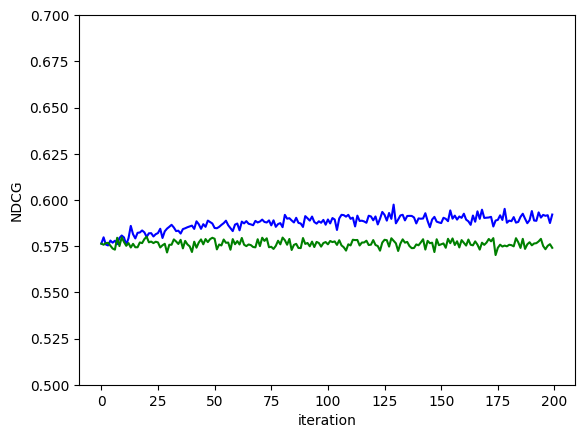

In [21]:
ucb_metrics_pdf = pd.DataFrame(ucb_metrics)
rnd_metrics_pdf = pd.DataFrame(rnd_metrics)

plt.plot(ucb_metrics_pdf['NDCG@10'], color='b')
plt.plot(rnd_metrics_pdf['NDCG@10'], color='g')
plt.xlabel('iteration')
plt.ylabel('NDCG')
plt.ylim(0.5, 0.7)

(0.2, 0.3)

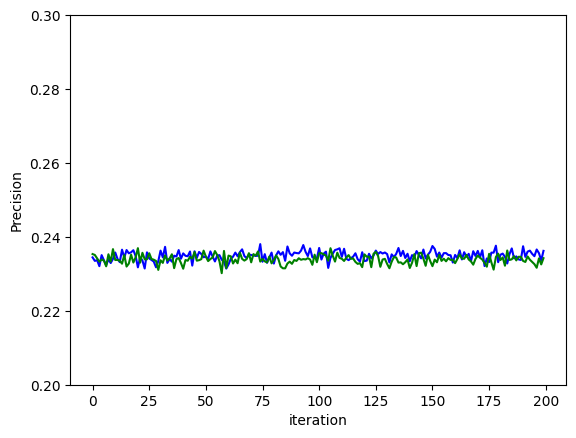

In [22]:
plt.plot(ucb_metrics_pdf['Precision@10'], color='b')
plt.plot(rnd_metrics_pdf['Precision@10'], color='g')
plt.xlabel('iteration')
plt.ylabel('Precision')
plt.ylim(0.2, 0.3)

(0.4, 0.6)

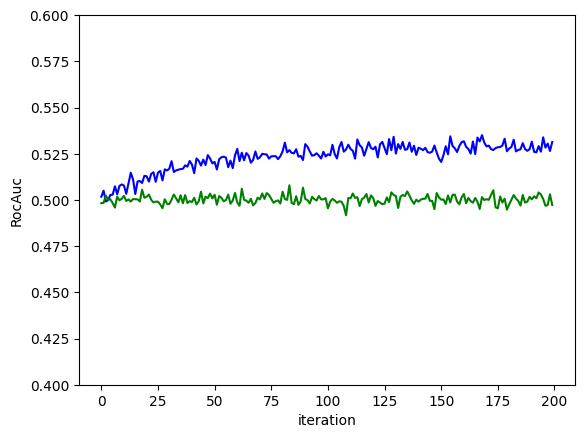

In [23]:
plt.plot(ucb_metrics_pdf['RocAuc@10'], color='b')
plt.plot(rnd_metrics_pdf['RocAuc@10'], color='g')
plt.xlabel('iteration')
plt.ylabel('RocAuc')
plt.ylim(0.4, 0.6)